In [1]:
import pandas as pd
df = pd.read_csv('c:/data/coin/market-price.csv')
df

,date,price
0,2017-08-27 00:00:00,4354.308333
1,2017-08-28 00:00:00,4391.673517
2,2017-08-29 00:00:00,4607.985450
3,2017-08-30 00:00:00,4594.987850
4,2017-08-31 00:00:00,4748.255000
...,...,...
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231


<AxesSubplot:>

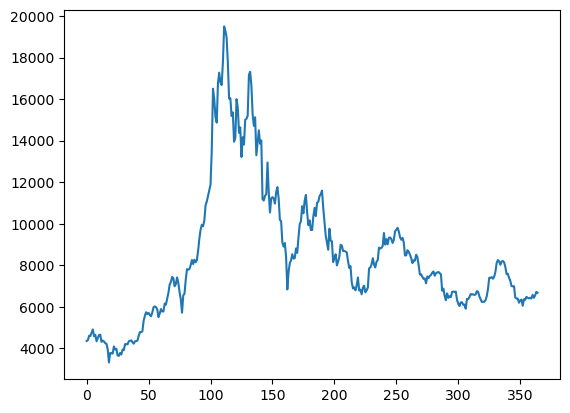

In [2]:
df['price'].plot() # 불안정한 시계열

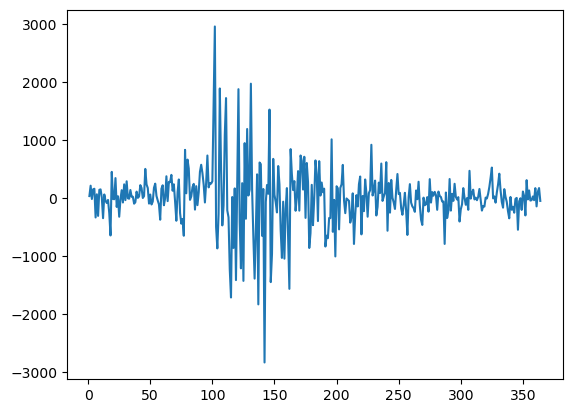

In [3]:
#1차 차분 데이터
import matplotlib.pyplot as plt
diff1 = df['price'].diff(periods=1).iloc[1:]
diff1.plot()
plt.show()

In [4]:
#로그 후 차분한 자료가 안정적인 시계열인지 확인
from statsmodels.tsa.stattools import adfuller
import numpy as np
diff1 = np.log(df['price']).diff(periods=1).iloc[1:]
result = adfuller(diff1)
print(result)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

(-7.390010724986963, 8.046990224984702e-11, 4, 359, {'1%': -3.4486972813047574, '5%': -2.8696246923288418, '10%': -2.571077032068342}, -1099.7979101893807)
ADF Statistic: -7.390011
p-value: 0.000000


In [5]:
#가장 적절한 모형
from pmdarima.arima import auto_arima
model = auto_arima(df['price'], suppress_warnings=True)
model

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [6]:
#학습용, 검증용 구분
n = int(df.shape[0] * 0.8)
train = df[:n]
test = df[n:]
print(len(df['price']))
print(train['price'].values)
print(test['price'].values)

365
[ 4354.30833333  4391.67351667  4607.98545     4594.98785
  4748.255       4911.74001667  4580.38748     4648.15998333
  4344.09831667  4488.72014     4641.82201667  4654.6585
  4310.75018333  4375.55952     4329.955       4248.09001667
  4219.03661667  3961.27126667  3319.63        3774.26528333
  3763.62604     3746.06078333  4093.31666667  3943.41333333
  3977.56166667  3658.89818333  3637.50255     3776.3869
  3703.04065     3942.555       3910.30738333  4202.55498333
  4201.98905     4193.57466667  4335.36831667  4360.72296667
  4386.88375     4293.3066      4225.175       4338.852
  4345.60333333  4376.19166667  4602.28088333  4777.96781667
  4782.28        4819.48576667  5325.13068333  5563.80656667
  5739.43873333  5647.31166667  5711.20586667  5603.71294
  5546.1761      5727.6335      5979.45984     6020.37168333
  5983.18455     5876.07986667  5505.82776667  5669.62253333
  5893.13841667  5772.50498333  5776.69695     6155.43402
  6105.87422     6388.64516667  6665.30668

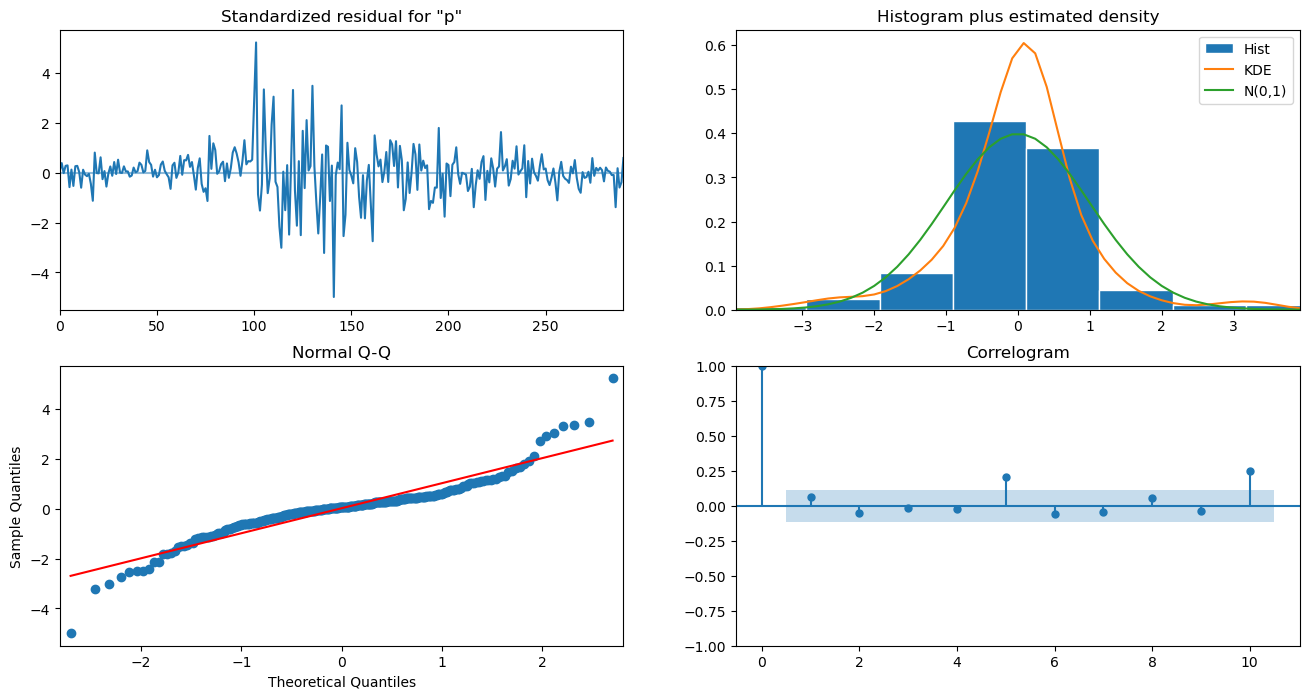

In [14]:
#가장 적절한 모형 생성
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['price'], order=(0,1,0)).fit()
model.plot_diagnostics(figsize=(16,8))
plt.show()

In [15]:
#예측값
predictions = model.predict(start=1, end=len(test), dynamic=False)
predictions.index = len(train) + (predictions.index) - 1
predictions

292    4354.308333
293    4391.673517
294    4607.985450
295    4594.987850
296    4748.255000
          ...     
360    7197.720060
361    7437.543317
362    7377.012367
363    6989.071667
364    7092.127233
Name: predicted_mean, Length: 73, dtype: float64

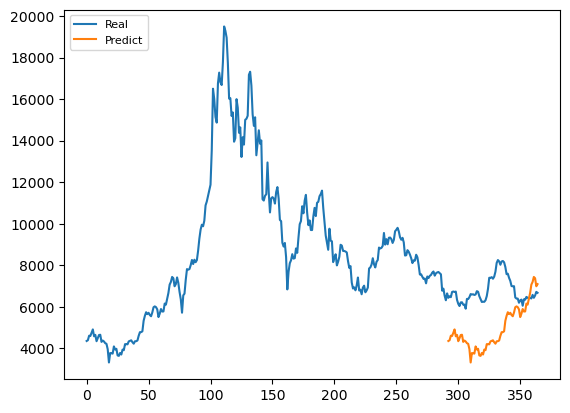

In [16]:
#시각화
plt.plot(df['price'], label='Real')
plt.plot(predictions, label='Predict')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [17]:
#오차 확인
def _error(real, pred):
    return real - pred

def mse(real, pred):
    return np.mean(np.square(_error(real, pred)))

def rmse(real, pred):
    return np.sqrt(mse(real, pred))

def mae(real, pred):
    return np.mean(np.abs(_error(real, pred)))

METRICS = {
    'mse': mse,
    'rmse': rmse,
    'mae': mae,
}

def evaluate(real, pred, metrics=('mse', 'rmse', 'mae')):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](real, pred)
        except:
            results[name] = np.nan
    return results

evaluate(test['price'].values, predictions.values)

{'mse': 4862708.949664892,
 'rmse': 2205.155085173125,
 'mae': 1934.3186223332834}